In [20]:
from pathlib import Path

import hydra
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from omegaconf import OmegaConf

from diffusion_reward.models.video_models.videogpt.transformer import VideoGPTTransformer
import pickle
from types import SimpleNamespace
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import scipy

config_path = '/home/dongyoon/diffusion_reward/dongyoon/config/viper_oneleg.yaml'

class CustomVIPER(nn.Module):
    def __init__(self, cfg):
        super(CustomVIPER, self).__init__()

        # load video models
        self.model_cfg = OmegaConf.load(cfg.cfg_path)
        self.model = VideoGPTTransformer(self.model_cfg)
        self.model.load_state_dict(torch.load(cfg.ckpt_path))
        self.model.eval()
        for param in self.model.parameters(): 
            param.requires_grad = False

        # set attribute
        for attr_name, attr_value in vars(cfg).items():
            setattr(self, attr_name, attr_value)
        
    def imgs_to_batch(self, x, reward_type='likelihood'):
        '''
        input:
            imgs: B * T * H * W * C
            (mostly): 1 * T * ...
        '''
        seq_len = x.shape[1] # T
        num_frames = self.model_cfg.num_frames + 1
        n_skip = self.model_cfg.frame_skip
        subseq_len = self.model_cfg.num_frames * n_skip # 4 * 16 = 64

        x = x.permute(0, 1, 4, 2 ,3) # B * T * C * H * W
        embs, indices = self.model.encode_to_z(x) 
        indices = indices.reshape(indices.shape[0], seq_len, -1) # [1, T, 256]
        embs = embs.reshape(embs.shape[0], seq_len, indices.shape[-1], -1) # [1, T, 256, 64]
        
        if reward_type == 'likelihood':
            post_idxes = list(range(seq_len - subseq_len)) # T - 64
            
            #batch_indices = [indices[:, idx:idx+subseq_len+n_skip:n_skip] for idx in post_idxes] # T, T+16, T+32, T+48, T+64, post_idxes:0~T-64
            batch_indices = []
            for idx in post_idxes:
                idx_idx = [idx+n_skip, idx+2*n_skip, idx+3*n_skip, idx+4*n_skip, min(idx+5*n_skip, seq_len-1)]
                batch_indices.append(indices[:, idx_idx])
            # [1, 5, 256]
            batch_indices = torch.stack(batch_indices, dim=0)
            batch_indices = batch_indices.squeeze(1).reshape(batch_indices.shape[0], -1) # [1280]
            
            #batch_embs = [embs[:, idx:idx+subseq_len+n_skip:n_skip] for idx in post_idxes]
            batch_embs = []
            for idx in post_idxes:
                idx_idx = [idx+n_skip, idx+2*n_skip, idx+3*n_skip, idx+4*n_skip, min(idx+5*n_skip, seq_len-1)]
                batch_embs.append(embs[:, idx_idx])
            # [64, 1280]
            batch_embs = torch.stack(batch_embs, dim=0) # [36, 1, 5, 256, 64]
            batch_embs = batch_embs.squeeze(1).reshape(batch_embs.shape[0], -1, batch_embs.shape[-1]) # [36, 1280, 64]
            
            pre_batch_indices = []
            for idx in range(subseq_len):
                idx_idx = [max(idx-3*n_skip, 0),max(idx-2*n_skip, 0),max(idx-1*n_skip, 0),idx,min(idx+n_skip, seq_len-1)]
                pre_batch_indice = torch.cat([indices[:, idx_idx[0]], indices[:, idx_idx[1]], indices[:, idx_idx[2]], indices[:, idx_idx[3]], indices[:, idx_idx[4]]], dim=1)
                pre_batch_indices.append(pre_batch_indice)
            #pre_batch_indices = [indices[:, min(idx+n_skip, seq_len-1)].tile((1, num_frames)) for idx in range(subseq_len)] # 64 * [1280]
            pre_batch_indices = torch.concat(pre_batch_indices, dim=0) # [64, 1280]
            batch_indices = torch.concat([pre_batch_indices, batch_indices], dim=0) # [128, 1280]

            pre_batch_embs = []
            for idx in range(subseq_len):
                idx_idx = [max(idx-3*n_skip, 0),max(idx-2*n_skip, 0),max(idx-1*n_skip, 0),idx,min(idx+n_skip, seq_len-1)]
                pre_batch_emb = torch.cat([embs[:, idx_idx[0]], embs[:, idx_idx[1]], embs[:, idx_idx[2]], embs[:, idx_idx[3]], embs[:, idx_idx[4]]], dim=1)
                pre_batch_embs.append(pre_batch_emb)
            #pre_batch_embs = [embs[:, min(idx+n_skip, seq_len-1)].tile((1, num_frames, 1)) for idx in range(subseq_len)]
            pre_batch_embs = torch.concat(pre_batch_embs, dim=0)
            batch_embs = torch.concat([pre_batch_embs, batch_embs], dim=0)
        elif reward_type == 'entropy':
            post_idxes = list(range(seq_len - subseq_len + 2))
            batch_indices = [indices[:, idx:idx+subseq_len-n_skip:n_skip] for idx in post_idxes]
            batch_indices = torch.stack(batch_indices, dim=0)
            batch_indices = batch_indices.squeeze(1).reshape(batch_indices.shape[0], -1)
            batch_embs = [embs[:, idx:idx+subseq_len-n_skip:n_skip] for idx in post_idxes]
            batch_embs = torch.stack(batch_embs, dim=0)
            batch_embs = batch_embs.squeeze(1).reshape(batch_embs.shape[0], -1, batch_embs.shape[-1])

            pre_batch_indices = [indices[:, idx].tile((1, num_frames-1)) for idx in range(subseq_len-2)]
            pre_batch_indices = torch.concat(pre_batch_indices, dim=0)
            batch_indices = torch.concat([pre_batch_indices, batch_indices], dim=0)

            pre_batch_embs = [embs[:, idx].tile((1, num_frames-1, 1)) for idx in range(subseq_len-2)]
            pre_batch_embs = torch.concat(pre_batch_embs, dim=0)
            batch_embs = torch.concat([pre_batch_embs, batch_embs], dim=0)
        else:
            raise NotImplementedError

        return batch_embs, batch_indices
    
    @torch.no_grad()
    def calc_reward(self, imgs):
        batch_embs, batch_indices = self.imgs_to_batch(imgs, self.reward_type)
        batch_embs = batch_embs.to('cuda:5')
        batch_indices = batch_indices.to('cuda:5')
        sos_tokens = self.model.calc_sos_tokens(imgs, batch_embs).tile((batch_embs.shape[0], 1, 1))
        sos_tokens = sos_tokens.to('cuda:5')

        rewards = self.cal_log_prob(batch_embs, batch_indices, sos_tokens, target_indices=batch_indices, reward_type=self.reward_type)
        return rewards  
    
    @torch.no_grad()
    def cal_log_prob(self, embs, x, c, target_indices=None, reward_type='likelihood'):
        self.model.eval()
        if not self.model.use_vqemb:
            x = torch.cat((c, x), dim=1) if x is not None else c   
        else:
            x = torch.cat((c, embs), dim=1) if x is not None else c
            
        logits, _ = self.model.transformer(x[:, :-1])
        probs = F.log_softmax(logits, dim=-1)

        if reward_type == 'likelihood':
            target = F.one_hot(target_indices, num_classes=self.model_cfg.codec.num_codebook_vectors)
            if self.compute_joint:
                rewards = (probs * target).sum(-1).sum(-1, keepdim=True)
            else:
                num_valid_logits = int(logits.shape[1] // (self.model_cfg.num_frames + 1))
                rewards = (probs * target).sum(-1)[:, -num_valid_logits:].sum(-1, keepdim=True)
        elif reward_type == 'entropy':
            num_valid_logits = int(logits.shape[1] // (self.model_cfg.num_frames))
            entropy = (- probs * probs.exp()).sum(-1)[:, -num_valid_logits:].sum(-1, keepdim=True)
            rewards = - entropy
        else:
            raise NotImplementedError

        # if self.use_std:
        #     rewards_std = (rewards - self.stat[0]) / self.stat[1]
        # scaled_rewards = (1 - self.expl_scale) * rewards_std
        return rewards

    def update(self, batch):
        metrics = dict()

        if self.use_expl_reward:
            metrics.update(self.expl_reward.update(batch))
        return metrics
    
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    config = SimpleNamespace(**config)
reward_model = CustomVIPER(config)
if torch.cuda.is_available():
    reward_model = reward_model.to('cuda:5')
    reward_model.model = reward_model.model.to('cuda:5')
    reward_model.model.transformer = reward_model.model.transformer.to('cuda:5')
    reward_model.model.vqgan = reward_model.model.vqgan.to('cuda:5')

def pkl2frames(pkl_path): # pkl -> T * H * W * C
    with open(pkl_path, 'rb') as file:
        data = pickle.load(file)
    frames = []
    for i in range(len(data['observations'])):
        frames.append(data['observations'][i]['color_image2'])
    frames = np.array(frames)
    frames = frames.transpose(0, 2, 3, 1) # T * C * H * W -> T * H * W * C
    frames_resized = []
    for j, frame in enumerate(frames):
        frame = Image.fromarray(frame)
        frame = frame.resize((64, 64)) # resize to 64x64
        frames_resized.append(np.array(frame))
    frames = np.array(frames_resized)    
    return frames

def process_frames(frames): # T * H * W * C -> 1 * T * C * H * W, tensor
    frames = np.expand_dims(frames, axis=0) # dim 0 for batch
    frames = frames.astype(np.float32)
    frames = frames / 127.5 - 1 # normalize to [-1, 1]
    frames = torch.from_numpy(frames).float().to('cuda:5')
    return frames

def extract_reward_100(combined_array, reward_model):
    """
    combined_array: T * H * W * C
    """
    reward_traj = np.zeros(0)
    start_idx = 0
    prev_last_idx = 0
    last_idx = 150
    while start_idx <= combined_array.shape[0]:
        last_frame = min(last_idx, combined_array.shape[0])
        if last_frame-start_idx < 100:
            start_idx -= 100
        selected_frames = combined_array[start_idx:last_frame]
        frames = process_frames(selected_frames)
        reward = reward_model.calc_reward(frames)
        reward = reward.cpu().numpy().squeeze()
        
        reward = reward[prev_last_idx-start_idx:]
        reward_traj = np.concatenate((reward_traj, reward))
        
        start_idx = last_idx - 20
        prev_last_idx = last_idx
        last_idx = start_idx + 150
    return reward_traj

In [21]:
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    config = SimpleNamespace(**config)
reward_model = CustomVIPER(config)
if torch.cuda.is_available():
    reward_model = reward_model.to('cuda:5')
    reward_model.model = reward_model.model.to('cuda:5')
    reward_model.model.transformer = reward_model.model.transformer.to('cuda:5')
    reward_model.model.vqgan = reward_model.model.vqgan.to('cuda:5')

0
1
2
0
1
2


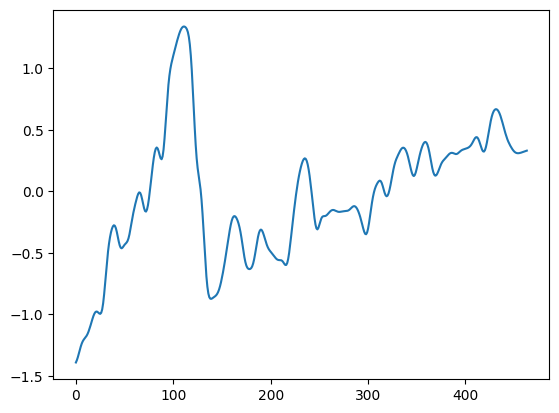

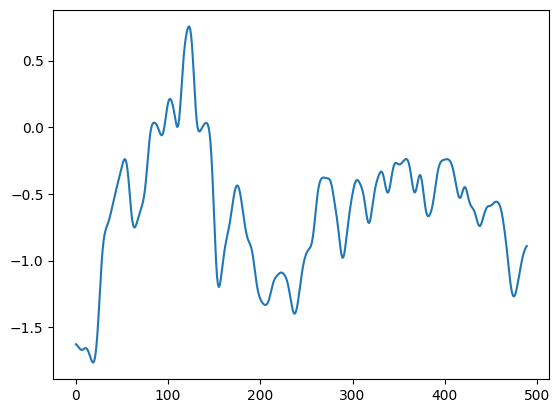

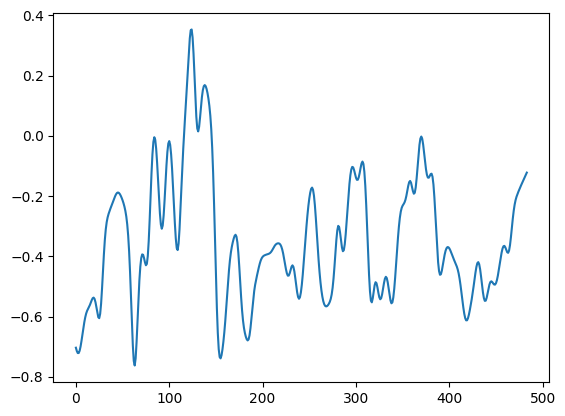

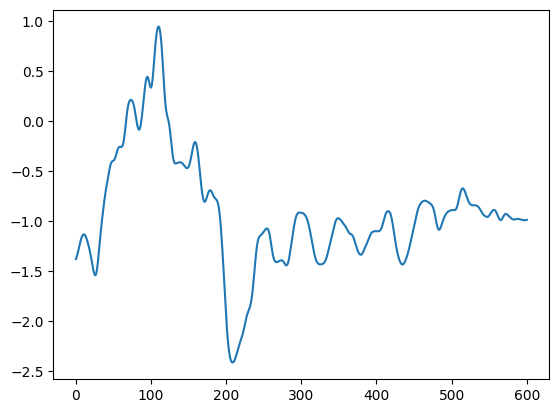

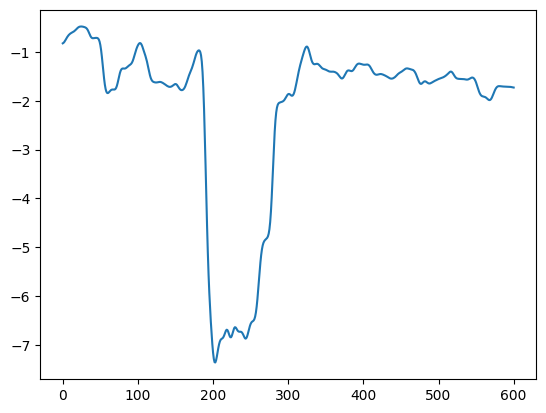

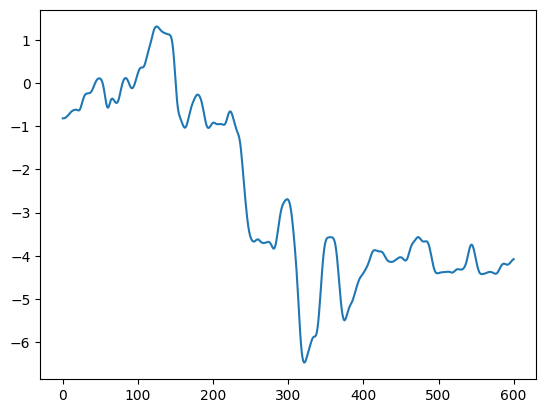

<Figure size 640x480 with 0 Axes>

In [22]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

succ_path = ['/home/dongyoon/FB_dataset/raw/low/one_leg/train/2023-12-07-20:53:08_success.pkl',
             '/home/dongyoon/FB_dataset/raw/low/one_leg/train/2023-12-07-21:01:43_success.pkl',
             '/home/dongyoon/FB_dataset/raw/low/one_leg/train/2023-12-07-21:20:34_success.pkl']
fail_path = ['/home/dongyoon/FB_dataset/raw/low/one_leg/train/2024-01-13-17:53:26_failure.pkl',
             '/home/dongyoon/FB_dataset/raw/low/one_leg/train/2024-01-13-18:20:23_failure.pkl',
             '/home/dongyoon/FB_dataset/raw/low/one_leg/train/2024-01-13-18:56:39_failure.pkl']

mean = -614.40232
std = 128.7201034
for i, pkl_path in enumerate(succ_path):
    print(i)
    with open(pkl_path, 'rb') as file:
        data = pickle.load(file)
    rewards = data['viper_reward_16']
    plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
    plt.figure()
    
for i, pkl_path in enumerate(fail_path):
    print(i)
    frames = pkl2frames(pkl_path)
    rewards = extract_reward_100(frames, reward_model)
    reward_std = (rewards - mean) / std
    reward_std = scipy.ndimage.gaussian_filter1d(reward_std, sigma=3,  mode="nearest")
    plt.plot(reward_std)
    plt.figure()


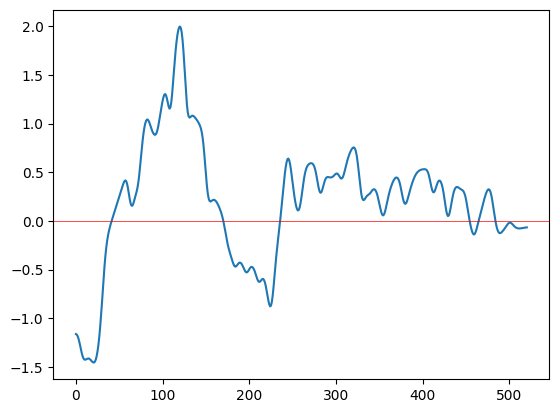

In [5]:
import pickle
import matplotlib.pyplot as plt
pkl_path = '/home/dongyoon/FB_dataset/raw/low/one_leg/train/2023-12-08-02:38:56_success.pkl'
with open(pkl_path, 'rb') as f: data = pickle.load(f)
plt.plot(data['viper_reward_16'])
plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)